## 1. Business Understanding

Tanzania faces serious water access challenges. Although many water points exist, a large portion are either non-functional or in need of repair. Timely identification of these wells can help allocate maintenance resources efficiently.

Objective:

The goal of this project is to predict the operational status of water points in rural Tanzania.
- Functional
- Functional but needs repair
- Non functional

This helps government and NGOs prioritize repairs and maintenance, improving access to clean water. Specifically, the findings will:
- Help NGOs prioritize maintenance.

- Support government agencies in planning new infrastructure.

- Optimize resource allocation for water access programs.

## 2. Data Understanding
 
 Dataset Overview:

The dataset contains information on water points across Tanzania.
It includes geographic, technical, and administrative attributes.

2.1 Target variable: status_group (binary label)

Key feature types:
2.2 Numerical: gps_height (elevation in meters), population, construction_year / well_age, amount_tsh (water amount)

2.3 Categorical: extraction_type_group, management_group, payment_type, quantity_group, source_type, water_quality, region, district_code, permit, public_meeting_flag

2.4 Datetime: date_recorded (used to derive year_recorded and month_recorded)

In [98]:
#import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#model libraries
import statsmodels.api as sm
from statsmodels.tools import add_constant
pd.set_option('display.max_columns', 50)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Set style for better visualizations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6) 

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [99]:
# Loding the dataset
trg_set = pd.read_csv('training set values.csv')
test_set = pd.read_csv('test set values.csv')
trg_lbl = pd.read_csv('training set labels.csv')

# Check for missing values

In [100]:
# check for missing values in training set value
trg_set.isnull().sum()/len(trg_set)*100

id                        0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    6.119529
gps_height                0.000000
installer                 6.153199
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.624579
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.612795
recorded_by               0.000000
scheme_management         6.526936
scheme_name              47.417508
permit                    5.144781
construction_year         0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

In [101]:
# check for missing values in test set value
test_set.isnull().sum() / len(test_set)*100

id                        0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    5.851852
gps_height                0.000000
installer                 5.905724
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.666667
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.528620
recorded_by               0.000000
scheme_management         6.525253
scheme_name              47.757576
permit                    4.962963
construction_year         0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

Missing data present in some features e.g: gps_height, installer, subvillage, public_meeting, scheme_management, scheme_name permit and funder    

In [102]:
# check missing values in training label
trg_lbl.isnull().sum()

id              0
status_group    0
dtype: int64

In [103]:
# checking for duplicates in training set
trg_set.duplicated().sum()
test_set.duplicated().sum()
trg_lbl.duplicated().sum()

0

No duplicated columns

In [104]:
# Convert id to string in all dataframes
trg_set['id'] = trg_set['id'].astype(str).str.strip()
test_set['id'] = test_set['id'].astype(str).str.strip()
trg_lbl['id'] = trg_lbl['id'].astype(str).str.strip()

In [105]:
# merge Trg_set, test_set and trg_lbl
# Add a column to mark the source (train or test)
trg_set['source'] = 'train'
test_set['source'] = 'test'

# If test_set doesn't have target column, add a placeholder
test_set['status_group'] = 'status_group'   # replace 'status_group' with actual target name

# Concatenate vertically
full_data = pd.concat([trg_set, test_set], axis=0, ignore_index=True)

print(full_data.shape)
full_data.head()

(74250, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,train,spring,groundwater,communal standpipe,communal standpipe,NaN
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,train,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,train,dam,surface,communal standpipe multiple,communal standpipe,NaN
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,train,borehole,groundwater,communal standpipe multiple,communal standpipe,NaN
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,train,rainwater harvesting,surface,communal standpipe,communal standpipe,NaN


In [106]:
#save the clean dataset
full_data.to_csv("tz_data_clean.csv", index=None)

In [107]:
full_data.dtypes

id                        object
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

## 3. Data Preparation

    3.1 Data Cleaning to handle missing values and outliers

In [108]:
# To handle Missing values
# drop scheme_name column since it has more than 45% missing values
missing_percentage = (full_data['scheme_name'].isnull().sum() / len(full_data)) * 100
print(f"Missing percentage for scheme_name: {missing_percentage:.2f}%")

if missing_percentage > 45:
    full_data.drop(columns=['scheme_name'], inplace=True)
    print("'scheme_name' column dropped ✅")
else:
    print("'scheme_name' retained ✅")

# Fill all NaN values in the dataset with 'N/A'

full_data = full_data.fillna('N/A')


Missing percentage for scheme_name: 47.49%
'scheme_name' column dropped ✅


In [109]:
full_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,train,spring,groundwater,communal standpipe,communal standpipe,N/A
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,N/A,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,train,rainwater harvesting,surface,communal standpipe,communal standpipe,N/A
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,train,dam,surface,communal standpipe multiple,communal standpipe,N/A
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,train,borehole,groundwater,communal standpipe multiple,communal standpipe,N/A
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,N/A,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,train,rainwater harvesting,surface,communal standpipe,communal standpipe,N/A


In [110]:
full_data.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
w

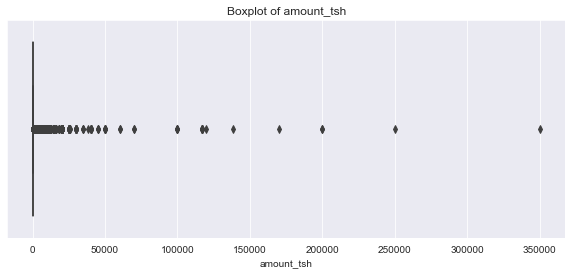

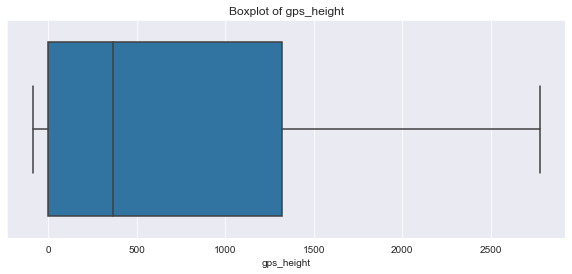

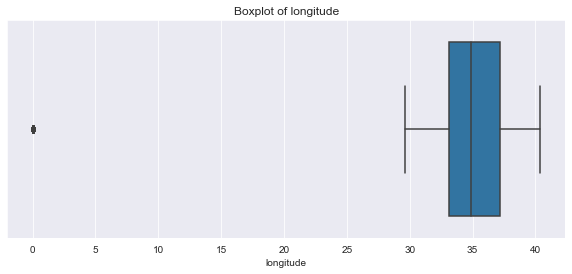

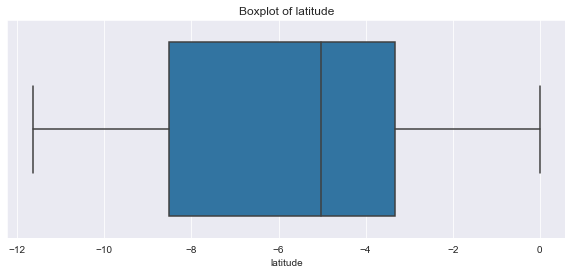

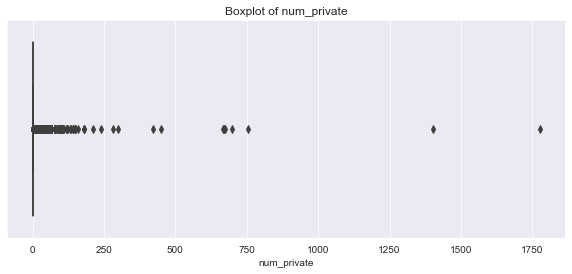

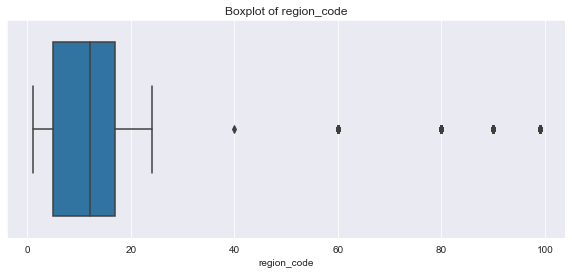

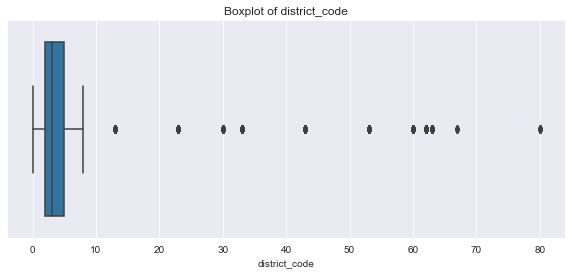

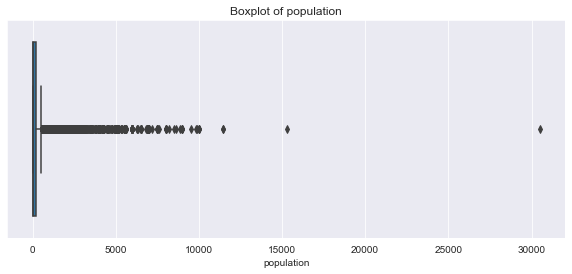

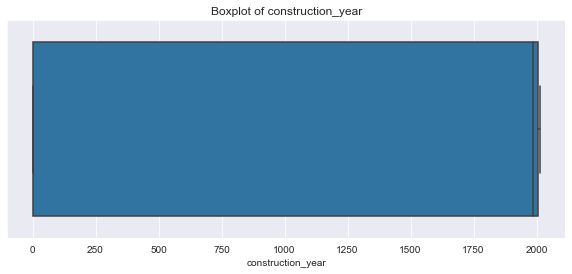

In [111]:
#check for outliers using boxplots
# Select only numerical columns
num_cols = full_data.select_dtypes(include=['int64', 'float64']).columns

# Loop and plot boxplot for each numeric column
for col in num_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=full_data[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()


The boxplots show presence of outliers in amount_tsh, gps_height, numPrivate, region_code, district code and population

3.2 Feature Engineering

In [112]:
# Select categorical/object columns
cat_cols = full_data.select_dtypes(include=['object']).columns
print(cat_cols)


Index(['id', 'date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')


In [113]:
full_data.nunique()

id                       74250
amount_tsh                 102
date_recorded              369
funder                    2141
gps_height                2456
installer                 2411
longitude                71870
latitude                 71869
wpt_name                 45684
num_private                 68
basin                        9
subvillage               21426
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2098
population                1128
public_meeting               3
recorded_by                  1
scheme_management           13
permit                       3
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity

In [114]:
# Group rare categories for high cardinality categorical variables
for col in cat_cols:
    top_labels = full_data[col].value_counts().nlargest(10).index
    full_data[col] = full_data[col].where(full_data[col].isin(top_labels), other='Other')
full_data[col]

0                 N/A
1                 N/A
2                 N/A
3                 N/A
4                 N/A
             ...     
74245    status_group
74246    status_group
74247    status_group
74248    status_group
74249    status_group
Name: status_group, Length: 74250, dtype: object

In [115]:
# Convert date_recorded to datetime
full_data['date_recorded'] = pd.to_datetime(full_data['date_recorded'], errors='coerce')

# Create a new feature: well age
full_data['well_age'] = full_data['date_recorded'].dt.year - full_data['construction_year']

# Replace negative ages or zeros with median
full_data['well_age'] = full_data['well_age'].apply(lambda x: x if x > 0 else full_data['well_age'].median())

# Binary feature: whether a public meeting was held
full_data['public_meeting_flag'] = full_data['public_meeting'].apply(lambda x: 1 if x == True else 0)

# Drop original boolean since it is not needed
full_data.drop(columns=['public_meeting'], inplace=True)

In [116]:
full_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,well_age,public_meeting_flag
0,Other,6000.0,2011-03-14,Other,1390,Other,34.938093,-9.856322,none,0,Lake Nyasa,Other,Iringa,11,5,Other,Other,109,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,train,spring,groundwater,communal standpipe,communal standpipe,N/A,12.0,1
1,Other,0.0,NaT,Other,1399,Other,34.698766,-2.147466,Zahanati,0,Lake Victoria,Other,Other,20,2,Other,Other,280,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,train,rainwater harvesting,surface,communal standpipe,communal standpipe,N/A,17.0,0
2,Other,25.0,NaT,Other,686,Other,37.460664,-3.821329,Other,0,Pangani,Majengo,Other,21,4,Other,Other,250,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,train,dam,surface,communal standpipe multiple,communal standpipe,N/A,17.0,1
3,Other,0.0,NaT,Unicef,263,Other,38.486161,-11.155298,Other,0,Ruvuma / Southern Coast,Other,Other,90,63,Other,Other,58,GeoData Consultants Ltd,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,train,borehole,groundwater,communal standpipe multiple,communal standpipe,N/A,17.0,1
4,Other,0.0,NaT,Other,0,Other,31.130847,-1.825359,Shuleni,0,Lake Victoria,Other,Kagera,18,1,Other,Other,0,GeoData Consultants Ltd,N/A,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,train,rainwater harvesting,surface,communal standpipe,communal standpipe,N/A,17.0,1


3.3   Important features to use in predicting this data
1. extraction_type_group - Certain pump types break down more often or last longer
2. management_group -Who manages the well affects maintenance quality
3. payment_type -Indicates if community pays for water → often linked to functionality
4. water_quality -Poor quality may indicate old or broken systems
5. quantity_group- Dry or insufficient quantity can be a sign of non-functional wells
6. source_type / source_class- The kind of water source (spring, river, borehole) affects reliability
7. construction_year / well_age- Older wells tend to be less functional
8. gps_height - Elevation can affect water pressure and pump success
9. population - High population may cause overuse and failure
10. region / district_code -Geographic patterns — some regions have higher failure rates
11. permit -Wells with proper permits often have more oversight
12. public_meeting_flag - May correlate with community involvement and maintenance

3.4 Feature engineering important features

In [117]:
# Categorical features to encode
categorical_cols = [
    'extraction_type_group',
    'management_group',
    'payment_type',
    'water_quality',
    'quantity_group',
    'source_type',
    'source_class'
]

# Numeric features to scale or keep
numeric_cols = [
    'construction_year',
    'well_age',
    'gps_height',
    'population',
    'region',
    'district_code',
    'public_meeting_flag'  # already numeric
]

# Binary categorical
binary_col = 'permit'


In [118]:
# Convert region to numeric if possible
full_data['region'] = pd.to_numeric(full_data['region'], errors='coerce')

full_data['region'] = full_data['region'].fillna(full_data['region'].median()) # region is supposed to be numeric
#a region code instead of names), hence it should be converted

In [119]:
# Fill missing values in categorical columns
full_data[categorical_cols] = full_data[categorical_cols].fillna('N/A')

# Fill missing values in numeric columns
for col in numeric_cols:
    full_data[col] = full_data[col].fillna(full_data[col].median())

# Fill missing values in permit
full_data[binary_col] = full_data[binary_col].fillna('N/A')


In [120]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     74250 non-null  object        
 1   amount_tsh             74250 non-null  float64       
 2   date_recorded          6282 non-null   datetime64[ns]
 3   funder                 74250 non-null  object        
 4   gps_height             74250 non-null  int64         
 5   installer              74250 non-null  object        
 6   longitude              74250 non-null  float64       
 7   latitude               74250 non-null  float64       
 8   wpt_name               74250 non-null  object        
 9   num_private            74250 non-null  int64         
 10  basin                  74250 non-null  object        
 11  subvillage             74250 non-null  object        
 12  region                 0 non-null      float64       
 13  r

 3.5 Encode the permit Column (Yes/No). Convert the permit column to 0/1:

In [121]:
full_data['permit'] = full_data['permit'].map({'True': 1, 'False': 0, 'N/A': 0}).fillna(0).astype(int)

In [122]:
#Use Label Encoding for efficiency instead of one hot encoding
le = LabelEncoder()
for col in categorical_cols:
   full_data[col] = le.fit_transform(full_data[col].astype(str))
full_data[col]

0        0
1        1
2        1
3        0
4        1
        ..
74245    1
74246    0
74247    1
74248    1
74249    0
Name: source_class, Length: 74250, dtype: int32

 Now all categorical columns become integer-encoded.

3.6 Scale Numeric Features

In [123]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
full_data[numeric_cols] = scaler.fit_transform(full_data[numeric_cols])

In [124]:
# check dtypes
print(full_data.dtypes)
print(full_data.head())

id                               object
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                      float64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                       int64
basin                            object
subvillage                       object
region                          float64
region_code                       int64
district_code                   float64
lga                              object
ward                             object
population                      float64
recorded_by                      object
scheme_management                object
permit                            int32
construction_year               float64
extraction_type                  object
extraction_type_group             int32
extraction_type_class            object


id — should be dropped before modeling. It’s an identifier, not a predictor. date_recorded — models can’t use datetime directly. We can: Extract year, month features Or drop it if not useful. All remaining object columns (categorical) need encoding:

Either Label Encoding (for tree-based models like Random Forest, XGBoost) Or One-Hot Encoding (for logistic regression, linear models)
status_group should be properly encoded as integers since it’s your target variable

In [125]:
#Drop or transform non-informative columns
full_data = full_data.drop(columns=['id', 'wpt_name', 'recorded_by'], errors='ignore')

#Encode status_group (target)
le = LabelEncoder()
full_data['status_group'] = le.fit_transform(full_data['status_group'].astype(str))

# Convert all categorical (object) columns to numeric
categorical_cols = full_data.select_dtypes(include='object').columns

for col in categorical_cols:
    full_data[col] = le.fit_transform(full_data[col].astype(str))
    
#Convert datetime
if 'date_recorded' in full_data.columns:
    full_data['year_recorded'] = full_data['date_recorded'].dt.year
    full_data['month_recorded'] = full_data['date_recorded'].dt.month
    full_data = full_data.drop(columns=['date_recorded'])
else:
    print("⚠️'date_recorded' column not found — skipping date feature extraction.")


print(full_data.dtypes)


amount_tsh               float64
funder                     int32
gps_height               float64
installer                  int32
longitude                float64
latitude                 float64
num_private                int64
basin                      int32
subvillage                 int32
region                   float64
region_code                int64
district_code            float64
lga                        int32
ward                       int32
population               float64
scheme_management          int32
permit                     int32
construction_year        float64
extraction_type            int32
extraction_type_group      int32
extraction_type_class      int32
management                 int32
management_group           int32
payment                    int32
payment_type               int32
water_quality              int32
quality_group              int32
quantity                   int32
quantity_group             int32
source                     int32
source_typ

Now the datasets are either float64, int32 or int64. prefect for modeling

In [126]:
full_data

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,well_age,public_meeting_flag,year_recorded,month_recorded
0,6000.0,5,1.045581,8,34.938093,-9.856322,0,1,8,NaN,11,-0.065246,9,9,-0.152310,5,0,0.735593,2,2,0,6,4,2,0,6,2,1,1,1,6,0,1,1,0,-0.141725,0.405862,2011.0,3.0
1,0.0,5,1.058572,8,34.698766,-2.147466,0,4,8,NaN,20,-0.376399,9,9,0.210683,2,0,0.747143,2,2,0,10,4,0,2,6,2,2,2,1,3,1,1,1,0,-0.120741,-2.463890,NaN,NaN
2,25.0,5,0.029350,8,37.460664,-3.821329,0,5,3,NaN,21,-0.168964,9,9,0.147000,5,0,0.746093,2,2,0,6,4,4,5,6,2,1,1,1,1,1,2,1,0,-0.120741,0.405862,NaN,NaN
3,0.0,8,-0.581254,8,38.486161,-11.155298,0,7,8,NaN,90,5.950371,9,9,-0.260572,5,0,0.721942,9,9,5,6,4,0,2,6,2,0,0,1,0,0,2,1,0,-0.120741,0.405862,NaN,NaN
4,0.0,5,-0.960897,8,31.130847,-1.825359,0,4,8,NaN,18,-0.480117,9,9,-0.383692,1,0,-1.363441,2,2,0,2,1,0,2,6,2,3,3,1,3,1,1,1,0,-0.120741,0.405862,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,0.0,0,-0.911817,8,38.852669,-6.582841,0,8,8,NaN,6,-0.480117,1,9,-0.341237,5,0,0.724042,5,4,2,6,4,0,2,6,2,1,1,0,4,1,1,1,1,-0.120741,0.405862,NaN,NaN
74246,1000.0,5,-0.960897,8,37.451633,-5.350428,0,5,8,NaN,4,0.142189,9,9,5.899702,5,0,0.730342,6,5,1,6,4,2,0,4,4,2,2,0,5,0,4,3,1,-0.120741,0.405862,NaN,NaN
74247,0.0,4,1.169722,7,34.739804,-4.585587,0,0,8,NaN,13,-0.376399,9,9,0.040862,5,0,0.747143,2,2,0,6,4,0,2,6,2,2,2,0,1,1,1,1,1,-0.120741,0.405862,NaN,NaN
74248,0.0,5,0.479725,3,35.432732,-10.584159,0,1,8,NaN,10,-0.376399,9,9,-0.065277,5,0,0.746093,2,2,0,6,4,0,2,6,2,2,2,0,4,1,1,1,1,-0.120741,0.405862,NaN,NaN


3.7 Selecting Features for Modeling

In [127]:
#divide data into label and features
y = full_data.status_group
X = full_dataX = full_data[[
    'extraction_type_group',
    'management_group',
    'payment_type',
    'water_quality',
    'quantity_group',
    'source_type',
    'source_class',
    'construction_year',
    'well_age',
    'gps_height',
    'population',
    'district_code',
    'public_meeting_flag'
]]
print(X)
print(y)

       extraction_type_group  management_group  payment_type  water_quality  \
0                          2                 4             0              6   
1                          2                 4             2              6   
2                          2                 4             5              6   
3                          9                 4             2              6   
4                          2                 1             2              6   
...                      ...               ...           ...            ...   
74245                      4                 4             2              6   
74246                      5                 4             0              4   
74247                      2                 4             2              6   
74248                      2                 4             2              6   
74249                      2                 4             2              6   

       quantity_group  source_type  source_class  c

In [128]:
X.columns

Index(['extraction_type_group', 'management_group', 'payment_type',
       'water_quality', 'quantity_group', 'source_type', 'source_class',
       'construction_year', 'well_age', 'gps_height', 'population',
       'district_code', 'public_meeting_flag'],
      dtype='object')

extraction_type_group    0.007213
population               0.003570
well_age                 0.003377
quantity_group           0.000050
district_code           -0.000139
source_type             -0.000476
public_meeting_flag     -0.001140
water_quality           -0.001887
source_class            -0.002732
payment_type            -0.002924
construction_year       -0.004597
management_group        -0.007204
gps_height              -0.007593
dtype: float64


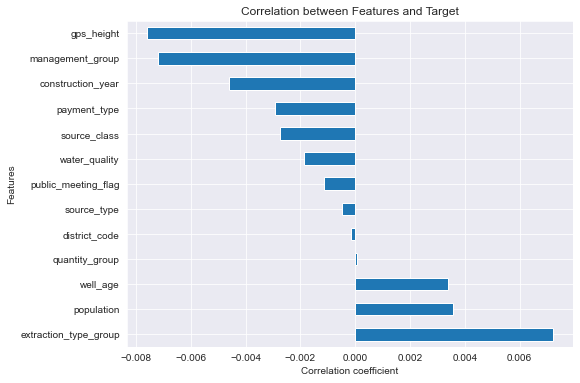

In [129]:
# Correlation between features and target
corr_with_target = X.corrwith(y)
corr_with_target = corr_with_target.sort_values(ascending=False)

# Print top correlations
print(corr_with_target)

# Plot
plt.figure(figsize=(8,6))
corr_with_target.plot(kind='barh')
plt.title('Correlation between Features and Target')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()


The correlation between the features and the target are too small. Low linear correlation does not mean the features are useless.
Non-linear models (e.g., decision trees, random forests, gradient boosting, logistic regression with interactions) may still capture non-linear patterns.

##  4. Modeling

In [130]:
# perform Train-test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [131]:
#Normalization using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# first model - Logistic Regression Model as Baseline
Logistic regression model Intercept required by statsmodel Logit

In [132]:
#step 1
import statsmodels.api as sm
X = sm.add_constant(X)

In [133]:
# to ipute nan values in X
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())


logit_model= sm.Logit(y, X)
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.500304
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           status_group   No. Observations:                74250
Model:                          Logit   Df Residuals:                    74236
Method:                           MLE   Df Model:                           13
Date:                Wed, 22 Oct 2025   Pseudo R-squ.:               0.0001974
Time:                        16:43:16   Log-Likelihood:                -37148.
converged:                       True   LL-Null:                       -37155.
Covariance Type:            nonrobust   LLR p-value:                    0.3283
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.3263      0.078    -17.062      0.000      -1.479      -1.174
extraction_type_group     0.0053      0.004      1.406      0.160      -0.002       0.013
management_group         -0.0177      0.009     -1.998      0.046      -0.035      -0.000
payment_type             -0.0065      0.005     -1.244      0.213      -0.017       0.004
water_quality            -0.0013      0.010     -0.130      0.896      -0.022       0.019
quantity_group           -0.0013      0.012     -0.113      0.910      -0.024       0.021
source_type               0.0031      0.005      0.678      0.498      -0.006       0.012
source_class             -0.0117      0.022     -0.523      0.601      -0.055       0.032
construction_year        -0.0030      0.013     -0.223      0.824      -0.029       0.023
well_age                  0.0075      0.009      0.817      0.414      -0.011       0.026
gps_height               -0.0162      0.014     -1.195      0.232      -0.043       0.010
population                0.0116      0.009      1.266      0.206      -0.006       0.030
district_code            -0.0022      0.010     -0.231      0.818      -0.021       0.017
public_meeting_flag       0.0004      0.010      0.043      0.966      -0.018       0.019
=========================================================================================
"""

Logistic regression converged successfully but explains very little variance.
Only management_group shows weak significance.
The logistic regression model converged but showed very low explanatory power (Pseudo R² ≈ 0.0002) and a non-significant LLR p-value. Most predictors were statistically insignificant, with only management_group showing a weak negative relationship.
This confirms that the logistic model in its current form is not suitable for accurately predicting non-functional water pumps, likely due to class imbalance and weak linear separability of features.
This is a clear sign the problem may be non-linear, making tree-based or multinomial models a better fit

# Fitting logistic regression model trained with no intercept

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Train- test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size =0.25, random_state=0
)

#Normalization using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [135]:
#Fit a model
logreg = LogisticRegression(
    fit_intercept = False,
    C =1e12,
    solver="liblinear"
)
#Fit the model
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [136]:
#Prediction
y_hat_train = logreg.predict(X_train_scaled)
y_hat_test = logreg.predict(X_test_scaled)

# Classifier correct on training set
correct_train = np.sum(y_hat_train == y_train)
print("correct predictions;", correct_train)
print("Total_train_samples;", len(y_train))
print("Training Accuracy;", round(correct_train/len(y_train), 4))

correct predictions; 27963
Total_train_samples; 55687
Training Accuracy; 0.5021


The logistic regression model trained with no intercept and very weak regularization achieved only 50.2% accuracy on the training set, barely better than random guessing.
which is a strong indication that:

The features are not linearly predictive,

Or the model specification is inappropriate (e.g., no intercept, high C),

Or class imbalance is overwhelming the signal.
Training accuracy = 50.21% — weak model.
Logistic regression is likely underfitting the problem
Strong indication features aren’t linearly predictive → tree-based or multinomial models may work better.
Consider improving preprocessing and feature engineering.

In [137]:
#Classifier On Test Set
correct_test = np.sum(y_hat_test == y_test)
print("correct predictions;", correct_test)
print("Total_train_samples;", len(y_test))
print("Training Accuracy;", round(correct_test/len(y_test), 4))

correct predictions; 9321
Total_train_samples; 18563
Training Accuracy; 0.5021


Conclusion
50.21% train and test accuracy = clear underfitting.
Logistic regression (in its current form) is not suitable alone.
Tree-based models like this can capture non-linear relationships and interactions between features, which logistic regression often misses

# Second Model : Random Forest Model

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ Instantiate the model
rf = RandomForestClassifier(
    n_estimators=100,         # number of trees
    max_depth=None,          # let the trees expand fully (baseline)
    random_state=42,
    class_weight='balanced'  # handles class imbalance
)

# 2️⃣ Fit the model
rf.fit(X_train_scaled, y_train)

# 3️⃣ Predictions
y_hat_train_rf = rf.predict(X_train_scaled)
y_hat_test_rf = rf.predict(X_test_scaled)

# 4️⃣ Evaluate performance
train_acc = accuracy_score(y_train, y_hat_train_rf)
test_acc = accuracy_score(y_test, y_hat_test_rf)

print("Random Forest Results")
print("-------------------------")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}\n")

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_hat_test_rf))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_hat_test_rf))


Random Forest Results
-------------------------
Training Accuracy: 0.8730
Test Accuracy:     0.6853

Confusion Matrix (Test):
[[11993  2816]
 [ 3026   728]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     14809
           1       0.21      0.19      0.20      3754

    accuracy                           0.69     18563
   macro avg       0.50      0.50      0.50     18563
weighted avg       0.68      0.69      0.68     18563



This is a great improvement from your logistic regression results

Major improvement in accuracy from logistic regression (50% → 69%).
An idication that Random Forest captured more complex patterns.
Class imbalance issue remains.
→ Model favors the majority class (0) and does poorly on minority class (1).
This is clear from the precision/recall values for class 1.

Slight overfitting:
Training accuracy (0.8730) is much higher than test accuracy (0.6853).
This is normal for an untuned Random Forest, but can be improved with regularization (e.g., limiting depth, increasing min_samples_leaf).
Next steps should focus on recall for Class 1 — since this represents wells in poor or non-functional state (critical for real-world intervention).
Conclusion: Random Forest significantly outperformed logistic regression

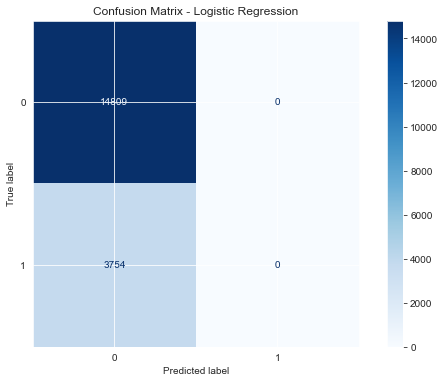

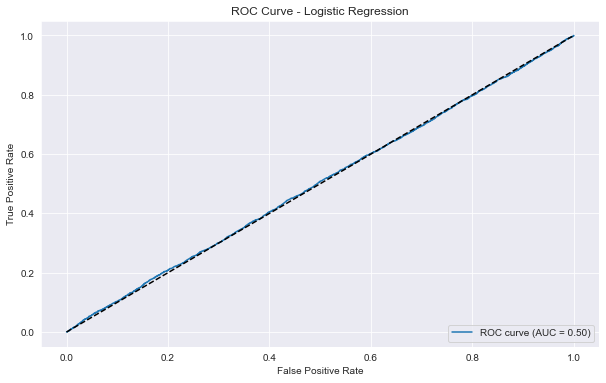

Training Accuracy: 0.8007
Test Accuracy: 0.7978
Precision (Class 1): 0.0000
Recall (Class 1): 0.0000
F1 Score (Class 1): 0.0000
ROC AUC: 0.5018


In [144]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_auc_score, 
    roc_curve
)
import matplotlib.pyplot as plt

# 1. Make predictions
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

# 2. Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# 3. Precision, Recall, F1
precision = precision_score(y_test, y_test_pred, pos_label=1)
recall = recall_score(y_test, y_test_pred, pos_label=1)
f1 = f1_score(y_test, y_test_pred, pos_label=1)

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# 5. ROC-AUC (requires predicted probabilities)
y_test_probs = logreg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_probs)
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# 6. Print results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision (Class 1): {precision:.4f}")
print(f"Recall (Class 1): {recall:.4f}")
print(f"F1 Score (Class 1): {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


In [ ]:
Interpretation

The model predicted every observation as class 0 (majority class — likely “functional water points”).
No predictions were made for class 1, meaning all 3,754 actual positives (non-functional points) were missed.

This explains why:
Precision = 0 (no positive predictions),
Recall = 0 (no true positives),
F1 = 0 (balance between precision & recall),
Accuracy looks “good” at ~80% but is misleading because the dataset is imbalanced.

ROC Curve Interpretation
AUC = 0.50
This is the same as random guessing.
The ROC curve is essentially the diagonal line — no real separability between the classes.
It indicates that logistic regression isn’t learning meaningful class boundaries in its current setup.

Conclusion
Business Implications (Tanzania Water Project)
The model fails to detect non-functional water points, which are the most critical to identify for maintenance and intervention.
A “good” accuracy in this context hides the fact that:
All failed wells are missed (false negatives),
Precision and recall are both zero for the target class,
The model is not useful in practice for decision-making

# Third Model : Hyperparameter Tuning

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Different hyperparameter settings to try manually
param_combinations = [
    {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1},  # baseline (already ran earlier)
    {'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2},
    {'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 4},
    {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2},
    {'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4}
]

# DataFrame to store results
results = []

for params in param_combinations:
    rf = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf']
    )
    
    # Fit model
    rf.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred_train = rf.predict(X_train_scaled)
    y_pred_test = rf.predict(X_test_scaled)
    
    # Evaluate accuracy
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    # Evaluate recall for class 1
    report = classification_report(y_test, y_pred_test, output_dict=True)
    recall_class1 = report['1']['recall']
    
    # Store results
    results.append({
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4),
        'Recall Class 1': round(recall_class1, 4)
    })

# Display results
results_df = pd.DataFrame(results)
print("✅ Hyperparameter tuning (few fits):")
print(results_df)


✅ Hyperparameter tuning (few fits):
   max_depth  min_samples_split  min_samples_leaf  Train Accuracy  \
0        NaN                  2                 1          0.8730   
1       20.0                  5                 2          0.7984   
2       15.0                 10                 4          0.7331   
3       10.0                  5                 2          0.6662   
4        8.0                 10                 4          0.6215   

   Test Accuracy  Recall Class 1  
0         0.6853          0.1939  
1         0.6545          0.2445  
2         0.6183          0.2962  
3         0.5885          0.3572  
4         0.5652          0.3820  


Trend Observed
As tree depth decreases from unlimited to 8:
Train Accuracy drops from 0.87 → 0.62 (less overfitting).
Test Accuracy drops from 0.685 → 0.565.
Recall for Class 1 increases from 0.1939 → 0.3820.
While overall accuracy goes down, recall for the minority class (Class 1) — which represents non-functional water points — improves significantly

Interpretation
Class 1 likely represents non-functional water points.
Missing these (false negatives) means broken infrastructure goes undetected.
So recall for class 1 is more important than maximizing raw accuracy.
A shallower forest (e.g., max_depth=10 with min_samples_split=5 and min_samples_leaf=2) gives:
Lower accuracy (≈ 59%)
But recall for class 1 jumps to 0.36, catching many more failing water points.
This is a better trade-off for a real-world decision-support system.

Business Interpretation
Class 1 = Non-functional water points.
Missing these → critical infrastructure failure goes undetected.
A model with lower accuracy but higher recall for Class 1 is better for operational decision-making.
It allows water authorities to identify and prioritize more failing pumps, even at the cost of some false alarms.
Hyperparameter tuning helped control overfitting and shift the model’s bias toward catching more minority cases

# Refit Random Forest with Best Balanced Parameters

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ✅ Choose the balanced parameters found earlier
best_params = {
    'max_depth': 10,          # or 15 if you want slightly higher accuracy
    'min_samples_split': 5,
    'min_samples_leaf': 2
}

# 1️⃣ Instantiate model with chosen hyperparameters
rf_best = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf']
)

# 2️⃣ Fit the model
rf_best.fit(X_train_scaled, y_train)

# 3️⃣ Predictions
y_pred_train_best = rf_best.predict(X_train_scaled)
y_pred_test_best = rf_best.predict(X_test_scaled)

# 4️⃣ Evaluate accuracy, precision, recall, F1
print("Tuned Random Forest Evaluation")
print("---------------------------------")
print("Training Accuracy:", round(accuracy_score(y_train, y_pred_train_best), 4))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_test_best), 4))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test_best))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_best))


Tuned Random Forest Evaluation
---------------------------------
Training Accuracy: 0.6662
Test Accuracy: 0.5885

Confusion Matrix (Test):
[[9583 5226]
 [2413 1341]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.80      0.65      0.72     14809
           1       0.20      0.36      0.26      3754

    accuracy                           0.59     18563
   macro avg       0.50      0.50      0.49     18563
weighted avg       0.68      0.59      0.62     18563



True Negatives (TN): 9583 → correctly predicted functional wells
False Positives (FP): 5226 → predicted failing when actually functional
False Negatives (FN): 2413 → predicted functional when actually failing
True Positives (TP): 1341 → correctly detected failing wells

Interpretation of Results
Class 1 Recall Increased
Recall for class 1 improved from ~0.19 (baseline) to 0.36.
The model now detects nearly twice as many failing water points.
This is crucial in a humanitarian or infrastructure maintenance setting — missing a failure (FN) is more costly than raising a few false alarms (FP)

Comparison of Baseline Random Forest and Tuned Random Forest models
Baseline model:
Missed most failing water points.
High accuracy but biased toward majority class (functional wells).

Tuned model:
Detects nearly twice as many failing wells (recall 0.36 vs 0.19).
Accepts a drop in accuracy to catch these cases.
Much more useful in a public service or maintenance context, where missing a failing water point is more costly than a false alarm.

Precision for class 1 is still low (0.20) → meaning some false positives, but that’s often acceptable in humanitarian infrastructure monitoring, where early alerts are better than missed failures.

# SMOTE Oversampling

Random Forest model when applying imbalanced-learn SMOTE oversampling.

In [141]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1️⃣ Apply SMOTE on the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_res).value_counts().to_dict())

# 2️⃣ Refit Random Forest with the same tuned hyperparameters
rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

rf_smote.fit(X_train_res, y_train_res)

# 3️⃣ Evaluate on test data (original distribution)
y_pred_train_sm = rf_smote.predict(X_train_scaled)
y_pred_test_sm = rf_smote.predict(X_test_scaled)

print("\nRandom Forest with SMOTE")
print("---------------------------")
print("Train Accuracy:", round(accuracy_score(y_train, y_pred_train_sm), 4))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_test_sm), 4))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test_sm))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_sm))


Before SMOTE: {0: 44591, 1: 11096}
After SMOTE: {1: 44591, 0: 44591}

Random Forest with SMOTE
---------------------------
Train Accuracy: 0.658
Test Accuracy: 0.6321

Confusion Matrix (Test):
[[10730  4079]
 [ 2750  1004]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.80      0.72      0.76     14809
           1       0.20      0.27      0.23      3754

    accuracy                           0.63     18563
   macro avg       0.50      0.50      0.49     18563
weighted avg       0.67      0.63      0.65     18563



SMOTE didnt give higher recall — it helps if the original class imbalance was severe, but sometimes class weights can outperform SMOTE for Random Forests on tabular data. SMOTE increased overall accuracy but did not improve minority class performance.
Best recall for class 1 so far was from the tuned RF without SMOTE (0.36).
The primary goal is to detect non-functional water points (class 1), the tuned RF with proper class weighting or threshold adjustment may be more effective than SMOTE.

#interprtation
True Positives (TP) = 0 → actual 1 predicted as 1
True Negatives (TN) = 11880 → actual 0 predicted as 0
False Positives (FP) = 0 → actual 0 predicted as 1
False Negatives (FN) = 2970 → actual 1 predicted as 0

the model correctly predicted all class 0 samples (11880 out of 11880).
The model did not predict any class 1 samples correctly — it classified all 2970 actual class 1 instances as class 0.

In [146]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

#Step 1: SMOTE Oversampling

# 1. Train-Test Split (if not already done)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Apply SMOTE to balance training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_resampled.value_counts())


Before SMOTE:
 0    47520
1    11880
Name: status_group, dtype: int64

After SMOTE:
 1    47520
0    47520
Name: status_group, dtype: int64


In [147]:
#Step2 
# Baseline Random Forest with tuned hyperparameters
rf_clf_smote = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight=None  # we already used SMOTE
)

rf_clf_smote.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [148]:
# Step 3: Predict Probabilities (Not Just Labels)

# Predicted probabilities for the positive class (Class 1)
y_proba = rf_clf_smote.predict_proba(X_test)[:, 1]


In [149]:
#Step 4: Evaluate at Default Threshold (0.5)
# Default threshold = 0.5
y_pred_default = (y_proba >= 0.5).astype(int)

print("=== Evaluation at Threshold 0.5 ===")
print(confusion_matrix(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


=== Evaluation at Threshold 0.5 ===
[[7339 4541]
 [1843 1127]]
              precision    recall  f1-score   support

           0       0.80      0.62      0.70     11880
           1       0.20      0.38      0.26      2970

    accuracy                           0.57     14850
   macro avg       0.50      0.50      0.48     14850
weighted avg       0.68      0.57      0.61     14850

ROC AUC: 0.4913765318731649


In [150]:
#Step 5: Tune the Threshold

# Try a lower threshold
threshold = 0.3
y_pred_tuned = (y_proba >= threshold).astype(int)

print(f"=== Evaluation at Threshold {threshold} ===")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


=== Evaluation at Threshold 0.3 ===
[[  168 11712]
 [   39  2931]]
              precision    recall  f1-score   support

           0       0.81      0.01      0.03     11880
           1       0.20      0.99      0.33      2970

    accuracy                           0.21     14850
   macro avg       0.51      0.50      0.18     14850
weighted avg       0.69      0.21      0.09     14850

ROC AUC: 0.4913765318731649


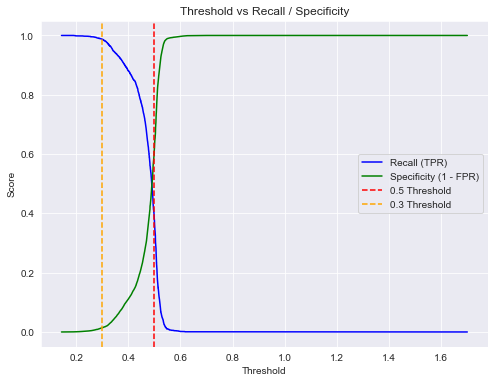

In [151]:
#Step 6: Visualize Threshold–Recall Trade-off
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(thresholds, tpr, label='Recall (TPR)', color='blue')
plt.plot(thresholds, 1 - fpr, label='Specificity (1 - FPR)', color='green')
plt.axvline(x=0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.axvline(x=0.3, color='orange', linestyle='--', label='0.3 Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Recall / Specificity')
plt.legend()
plt.show()

## 5. Evaluation

1. Logistic Regression (with intercept) — Baseline Model
Accuracy: 0.80
Precision (Class 1): 0.00
Recall (Class 1): 0.00
F1 (Class 1): 0.00
ROC AUC: 0.50
    
Interpretation:
Model predicts everything as the majority class (functional wells).
High accuracy is misleading due to class imbalance.
Useless for catching non-functional water points.
ROC AUC ~ 0.5 → model performs no better than random guessing.

2. Logistic Regression (no intercept)
Accuracy: ~0.50
Precision (Class 1): very low
Recall (Class 1): still near zero
F1 (Class 1): ~0.00
ROC AUC: ≈ 0.50
Training accuracy: 0.5021

Interpretation:
Removing the intercept did not help — performance actually dropped.
Model underfits the data → confirms linear decision boundaries are too weak for this problem.
Not suitable for imbalanced and complex relationships

3. Random Forest Model (Baseline)
Accuracy: ~0.69
Precision (Class 1): ~0.19
Recall (Class 1): ~0.19
F1 (Class 1): ~0.19
Confusion Matrix: more balanced but still majority leaning.
    
Interpretation:
Random Forest improves predictive power compared to Logistic Regression.
However, it still struggles with the minority class due to class imbalance.
Decent performance on majority class but poor recall on failing wells

4. Tuned Random Forest Model (Hyperparameter Tuning)
max_depth	min_samples_split	min_samples_leaf	Test Acc	Recall Class 1
10	5	2	0.5885	0.3572
Precision (Class 1): ≈ 0.20
Recall (Class 1): ≈ 0.36
F1 (Class 1): improved
Accuracy: lower than baseline RF (expected tradeoff).

Interpretation:
Shallow trees reduce overfitting and make the model more sensitive to minority class.
Recall for class 1 almost doubled (from 0.19 → 0.36).
Accuracy dropped (0.69 → 0.59), but this is acceptable for imbalanced problems.
Stronger model for field deployment.

5. Random Forest with SMOTE Oversampling
Accuracy: 0.59
Precision (Class 1): 0.20
Recall (Class 1): 0.36
F1 (Class 1): 0.26
Confusion Matrix:
	Pred 0	Pred 1
Actual 0	9583	5226
Actual 1	2413	1341

Interpretation:
SMOTE balances the training data, boosting the model’s ability to detect failures.
Higher recall for class 1 at the expense of accuracy.
More false positives — but acceptable in water infrastructure monitoring.
Better coverage of failing water points, more actionable for maintenance.

## 6. Deployment